梯度提升决策树（Gradient Boosting Decision Tree-GBDT）是梯度提升方法（GB）和决策树算法的结合，它是Boosting族中一个重要的算法，有很多简称，如GBT（Gradient Boosting Tree）, GTB（Gradient Tree Boosting ）， GBRT（Gradient Boosting Regression Tree）, MART(Multiple Additive Regression Tree)。基于梯度提升算法的学习器叫做GBM(Gradient Boosting Machine)。

疑问：
1. 如何初始化弱学习器
2. 如何理解负梯度的计算公式
3. 如何利用$(x_i,r_{ti}) \quad (i=1,2,...,m)$拟合一颗CART回归树

# GBDT回归算法

## GBDT回归算法流程（学习率$\alpha=1$）
GBDT使用的是M颗树组成的加法模型
$$F(x,\omega)=\sum_{m=0}^M \alpha_m h_m(x,\omega_m)$$

输入：
- 训练数据集$T={(x_1,y_1),(x_2,y_2),...,(x_N,y_N)}$，其中$x_i \in \chi \subseteq R^n$，$y_i \in Y \subseteq R$
- 损失函数$L(y,f(x))$

输出：最终回归树$f_M$

1. 初始化弱学习器$f_0(x)$
$$f_0(x)=arg \ min_c \sum_{i=1}^ML(y_i,c)$$
    - 初始的弱学习器在笛卡尔坐标系下就是平行于x轴的一条直线
2. $对m=1,2,...,M$  # 建立$M$颗回归树
    1. 对$i=1,2,...,N$，计算第$m$颗树的响应值（损失函数的负梯度，即残差近似值）  
    $$r_{mi}=-\left [ \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)} \right ] _{f(x)=f_{m-1}(x)}$$
        - 对于平方损失函数，拟合的就是残差；对于一般损失函数，拟合的就是残差的近似值。（eg：**若采用平方损失函数$L(y_i,f(x_i))=\frac{1}{2}(y_i-f(x_i))^2$，$r_{mi}=y_i-f(x_i)$，即残差**）
    2. $对i=1,2,...,N$，使用CART回归树拟合数据$(x_i,r_{mj})$,得到第$m$颗回归树，其对应叶结点区域为$R_{mj}$， $j=1,2,...,J$，$J$为第$m$颗树的叶结点的总数。  
        - **疑问：为何训练时要将$r_{mj}$作为标签值？**
            - A：因为要拟合的就是真实值与当前模型预测值的残差
        - 求回归树的方法：同CART回归树的生成方法
    3. 对$J$个叶节点区域$j=1,2,...,J$，计算出使得拟合效果最好的参数$c_{mj}$ $$c_{mj}=arg \ min_c \sum_{x_i \in R_{mj}}L(y_i,f_{m-1}(x_i)+c)$$
        - **参数$c_{mj}$的含义**：若采用平方损失函数，对于第$m$颗树，为每个叶子节点分别赋一个参数$c_{mj}$，来拟合残差
        - 求参数的方法：求一阶导数
    4. 更新强学习器$$f_m(x)=f_{m-1}(x)+\sum_{j=1}^J c_{mj}I(x \in R_{mj})$$
3. 得到强学习器$$f_M(x)=f_0(x)+\sum_{m=1}^M\sum_{j=1}^Jc_{mj}I(x \in R_{mj})$$

**小结**：
- GBDT回归算法中，要预设的参数：
    - 学习率（正则化项）
    - CART树深度
    - 迭代次数（基学习器总数）
- GBDT回归算法中，要学习内容：
    - 初始弱学习器
    - 每轮迭代中要学习的内容：
        - 第m个回归树（的结构，即叶结点区域）
        - 第m个学习器的参数$c_{mj}, \ j=1,2,...,J$

## GBDT回归常用的损失函数
sklearn实现了4种损失函数：
- 平方误差（默认）：'ls'。适合噪音不多的情况。
- 绝对值损失：'lad'。
- Huber损失：'huber'。适合噪音较多的情况。
- 分位数损失：'quantile'。适合需要对训练集分段预测时。

1. 平方误差$$L(y_i,f(x_i))=\frac{1}{2}(y_i-f(x_i))^2$$
对应的负梯度为$$y_i-f(x_i)$$

2. 绝对值损失$$|y_i-f(x_i)|$$
对应的负梯度为$$sign(y_i-f(x_i))$$

3. Huber损失：它是均方差和绝对损失的折衷产物，对于远离中心的异常点，采用绝对损失，而中心附近的点采用均方差。这个界限一般用分位数点度量。使用过程中可能需要调整参数$\delta$。$$L(y_i,f(x_i))=\left\{\begin{matrix} 
  \frac{1}{2}(y_i-f(x_i))^2，for \ |y_i-f(x_i)|≤\delta  \\  
  \delta |y_i-f(x_i)|-\frac{1}{2} \delta^2，\ otherwise
\end{matrix}\right. $$  
对应的负梯度为$$r(y_i,f(x_i))=\left\{\begin{matrix} 
  y_i-f(x_i),   for \ |y_i-f(x_i)|≤\delta\\  
  \delta·sign(y_i-f(x_i))，\ otherwise
\end{matrix}\right. $$  
![](squared_lossand_and_Huber_loss.png)

4. 分位数损失：对应的是分位数回归的损失函数$$L(y_i,f(x_i))=\sum_{y_i≥f(x_i)}\theta|y_i-f(x_i)|+\sum_{y_i<f(x_i)}(1-\theta)|y_i-f(x_i)|$$，$\theta$为分位数，需要预先指定。对应的负梯度为
$$r(y_i,f(x_i))=\left\{\begin{matrix} 
  \theta \quad y_i≥f(x_i)\\  
  \theta-1 \quad otherwise
\end{matrix}\right. $$  

## 正则化
正则化有多种方法，下面介绍几种。

### 早停法（Early Stopping）
选择一部分样本作为验证集，在迭代拟合训练集的过程中，如果模型在验证集里错误率不再下降，就停止训练。可以用于控制迭代的轮数（树的个数）。**在sklearn的GBDT中可以设置参数n_iter_no_change实现early stopping**。

### Shrinkage方法
在这种方法中，对于前面的弱学习器的迭代：$$f(x)=f_{m-1}(x)+h_m(x)$$，加上一个正则化项$\alpha$后，则有$$f(x)=f_{m-1}(x)+\alpha h_m(x)$$，$\alpha$也叫做学习率。学习率越小，所需的迭代次数也就越多。

在**实际调参中推荐将learning_rate设置为一个小的常数（e.g. learning_rate <= 0.1），并通过early stopping机制来选n_estimators**。

### 子采样比例（Subsample）
这种方法从训练集中进行不放回抽样（取值是$(0,1]$），对抽样的样本进行拟合。可以减小方差，但会增大偏差。**一般建议设置在$[0.5, 0.8]$**。

**使用了子采样的GBDT有时也称作随机梯度提升树 (Stochastic Gradient Boosting Tree, SGBT)**。由于使用了子采样，程序可以通过采样分发到不同的任务去做Boosting的迭代过程，最后形成新树，从而克服弱学习器难以并行学习的弱点。

### 剪枝
这一方法见CART的剪枝。

# GBDT二分类算法
**GBDT无论用于分类还是回归，一直使用的是CART回归树，不会因为我们所选择的任务是分类任务就选用分类树。**这是因为GBDT中每轮的训练是基于上一轮模型的的负梯度基础之上训练的。这要求真实标签与弱分类器的差是有意义的。如果采用分类树，则输出的是类别，类别与真实的标签类别相减没有意义。为了解决这个问题，有以下两种方法：

1. 采用指数损失函数，此时GBDT将退化为AdaBoost，可以解决问题。 
2. 使用类似于逻辑回归的对数似然损失函数，如此可以**通过结果的概率值与真实概率值的差距当做残差来拟合**（本文介绍对象）

## 原理
![](GBDT二分类的原理.png)

# GBDT的调参
在sacikit-learn中，GradientBoostingClassifier为GBDT分类算法对应类， 而GradientBoostingRegressor为GBDT回归算法对应类。两者的参数类型完全相同，除有些参数比如损失函数loss的可选项不同。

GBDT的调参也分为Boosting框架参数和弱学习器参数。

## GBDT类库的Boosting框架参数
1. n_estimators: 弱学习器的最大迭代次数/最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是100。在实际调参的过程中，常将n_estimators和下面介绍的参数learning_rate一起考虑。
2. learning_rate: 即每个弱学习器的权重缩减系数$ν$，也称作步长/学习率/正则化项。之前介绍过，加上了正则化项，强学习器的迭代公式为$f_k(x)=f_{k−1}(x)+ν·h_k(x)$。$ν$的取值范围为$0<ν≤1$。对于同样的训练集，较小的ν意味着需要更多的弱学习器的迭代次数。因此参数n_estimators和learning_rate要一起调参。一般来说，**可以从一个小一点的$ν$开始调参，默认是1**。
3. subsample: 子采样比例，取值为$(0,1]$。这里是不放回抽样。如果取值为1，则全部样本都使用，等于没有使用子采样。如果取值小于1，则只有一部分样本会去做GBDT的决策树拟合。选择小于1的比例可以减少方差，即防止过拟合，但是会增加样本拟合的偏差，因此取值不能太低。推荐在$[0.5, 0.8]$之间，**默认是1.0，即不使用子采样**。
4. init: 初始化的弱学习器，即前面介绍的$f_0(x)$。**如果不输入，则用训练集样本来做样本集的初始化分类回归预测。否则用init参数提供的学习器做初始化分类回归预测。**一般用在我们对数据有先验知识，或者之前做过一些拟合的时候，如果没有的话就不用管这个参数了。
5. loss: GBDT算法中的损失函数。分类模型和回归模型的损失函数是不一样的。
    - 对于分类模型，有对数似然损失函数"deviance"和指数损失函数"exponential"两者输入选择。默认是对数似然损失函数"deviance"。一般来说，推荐使用默认的"deviance"。它对二元分离和多元分类各自都有比较好的优化。而使用指数损失函数等于回到了Adaboost算法。
    - 对于回归模型，**有均方差"ls", 绝对损失"lad", Huber损失"huber"和分位数损失“quantile”。默认是均方差"ls"**。一般来说，若数据的噪点不多，用默认的均方差"ls"较好。若噪音点较多，则推荐用抗噪音的损失函数"huber"。而如果我们需要对训练集进行分段预测的时候，则采用“quantile”。
6. alpha：这个参数只有GradientBoostingRegressor有，**当我们使用Huber损失"huber"和分位数损失“quantile”时，需要指定分位数的值。默认是0.9，如果噪音点较多，可以适当降低这个分位数的值。**

## GBDT类库的弱学习器参数
GBDT使用CART作为基学习器，因此这类参数基本和DecisionTreeClassifier和DecisionTreeRegressor类似。这里省略。

## GBDT回归类库的实例
sklearn提供了`GradientBoostingRegressor`类以实现GBDT回归。

### 导入数据集
diabetes数据集基本信息：
![](diabetes数据集基本信息.png)
注：这10个特征变量均以均值为中心，并按标准差乘以n_samples进行缩放（即每列的平方和为1）。

In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

### 数据划分
选取数据集90%作为训练集，其余作为测试集。

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

### 建立模型


In [3]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,  # 迭代次数
          'max_depth': 4,  # 基回归树最大深度
          'min_samples_split': 5,  # 基回归树内部节点再划分所需最小样本数
          'learning_rate': 0.01,  # 学习率
          'loss': 'ls'}  # 损失函数

reg = GradientBoostingRegressor(**params)

### 模型训练

In [4]:
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

### 模型预测

In [5]:
y_predict = reg.predict(X_test)

### 模型评估

In [66]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_predict)
print("测试集均方误差：{:.4f}".format(mse))

测试集均方误差：3062.9143


### 可视化

**绘制每轮迭代后模型的偏差（这里使用均方误差）**

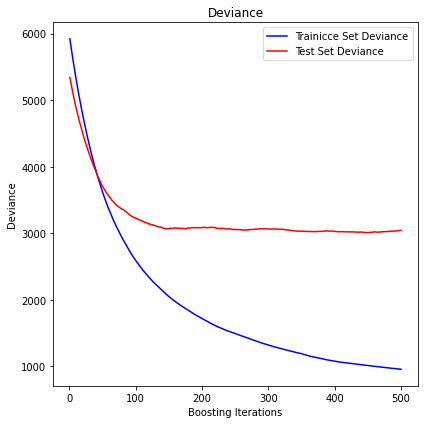

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_staged_loss(params, reg):
    test_score = np.zeros((params['n_estimators'], ), dtype=np.float64)  # 创建全0数组 以保存每次迭代后模型的MSE
    for i, y_pred in enumerate(reg.staged_predict(X_test)):  # 获取每次迭代后模型的MSE 保存到数组
        test_score[i] = reg.loss_(y_test, y_pred)  


    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title('Deviance')    
    plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
             label='Trainicce Set Deviance')  # reg.train_score_属性保存了每次迭代后训练集的损失
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')  # 图例位置
    plt.xlabel('Boosting Iterations')  
    plt.ylabel('Deviance')
    fig.tight_layout()
    plt.show()

plot_staged_loss(params, reg)    

- 根据上图我们可以得知，迭代次数在150次左右时，模型在测试集上的损失值基本不变，即模型基本收敛。

### 调参
1. 其他参数不变，减小迭代次数n_estimators到150


测试集均方误差：3072.4087


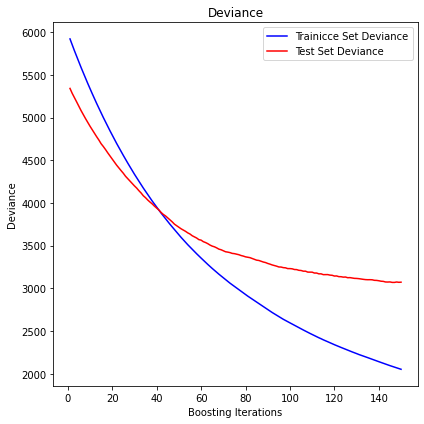

In [14]:
params = {'n_estimators': 150,  # 迭代次数
          'max_depth': 4,  # 基回归树最大深度
          'min_samples_split': 5,  # 基回归树内部节点再划分所需最小样本数
          'learning_rate': 0.01,  # 学习率
          'loss': 'ls'}  # 损失函数

def train_and_predict(params):
    reg = GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    print("测试集均方误差：{:.4f}".format(mse))
    
    return reg

################################################
reg = train_and_predict(params)
plot_staged_loss(params, reg)    

2. 其他参数不变，增大树的最大深度max_depth到6

测试集均方误差：3914.5518


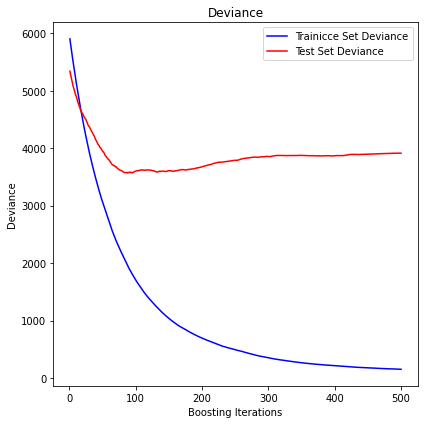

In [20]:
params = {'n_estimators': 500,  # 迭代次数
          'max_depth': 6,  # 基回归树最大深度
          'min_samples_split': 5,  # 基回归树内部节点再划分所需最小样本数
          'learning_rate': 0.01,  # 学习率
          'loss': 'ls'}  # 损失函数

reg = train_and_predict(params)
plot_staged_loss(params, reg) 

- 可以发现max_depth过大时，模型泛化能力变得很差。

3. 其他参数不变，增大学习率learning_rate到0.1

测试集均方误差：3714.1889


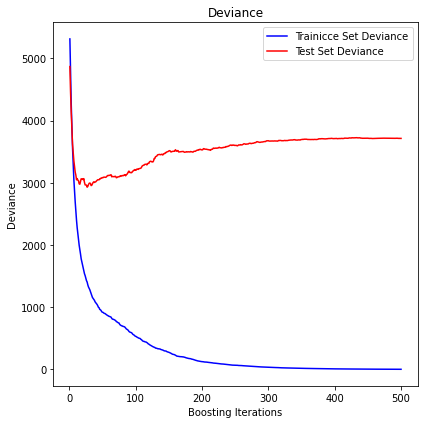

In [34]:
params = {'n_estimators': 500,  # 迭代次数
          'max_depth': 4,  # 基回归树最大深度
          'min_samples_split': 5,  # 基回归树内部节点再划分所需最小样本数
          'learning_rate': 0.1,  # 学习率
          'loss': 'ls'}  # 损失函数

reg = train_and_predict(params)
plot_staged_loss(params, reg) 

- 学习率过大时模型在测试集上的损失值会迅速达到最小，之后有可能反而增大（发生振荡）

4. 其他参数不变，增大min_samples_split（内部节点再划分所需最小样本数）

测试集均方误差：2947.7259


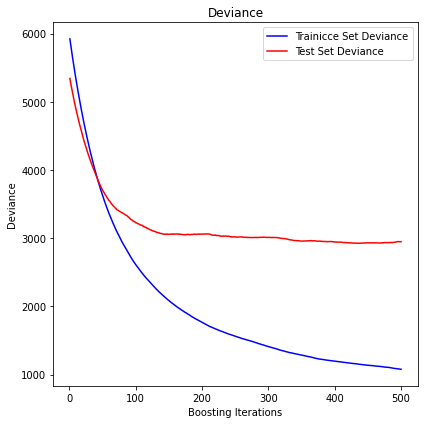

In [50]:
params = {'n_estimators': 500,  # 迭代次数
          'max_depth': 4,  # 基回归树最大深度
          'min_samples_split': 14,  # 基回归树内部节点再划分所需最小样本数
          'learning_rate': 0.01,  # 学习率
          'loss': 'ls'}  # 损失函数

reg = train_and_predict(params)
plot_staged_loss(params, reg) 

- 增大min_samples_split使得每颗树划分结点更苛刻，能够减小过拟合。

# GBDT的优缺点
主要优点
1. 可以灵活处理各种类型的数据，包括连续值和离散值。
2. 在相对少的调参时间情况下，预测的准确率也可以比较高。这个是相对 SVM 来说的。
3. 使用一些健壮的损失函数，对异常值的鲁棒性非常强。比如 Huber 损失函数和 Quantile 损失函数。

主要缺点
1. 由于弱学习器之间存在依赖关系，难以并行训练数据。不过可以通过自采样的 SGBT 来达到部分并行。

# Reference

1. [深入理解GBDT回归算法](https://mp.weixin.qq.com/s?__biz=MzI5NDMzMjY1MA==&mid=2247485231&idx=1&sn=1fe835f3bd9f6d2062273a02b78dea2f&chksm=ec6536aadb12bfbc548ab0a2a1cbf1c77e9d2e8517886f54b616d6f8aa8d34dc371542a82919&scene=158#rd)
2. [scikit-learn 梯度提升树(GBDT)调参小结](https://www.cnblogs.com/pinard/p/6143927.html)